In [27]:
from __future__ import division
import imageio
import numpy as np
import scipy as sp
import scipy.fftpack as ft
import PIL
import cv2
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


c:\users\roland\appdata\local\programs\python\python37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['compress']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


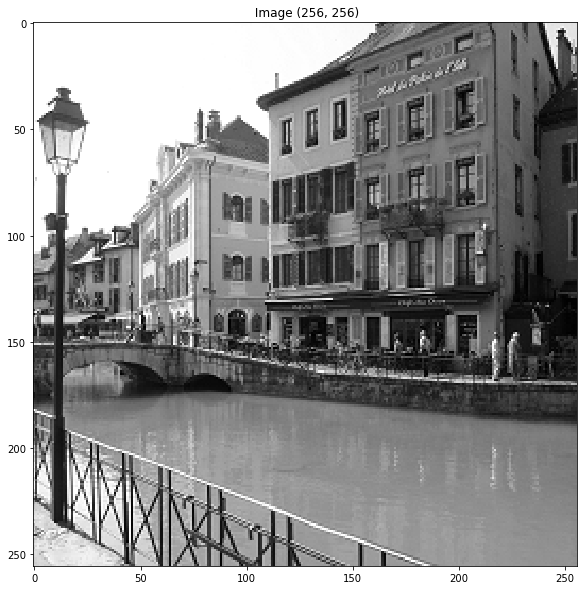

In [28]:
import imageio as imio
image = imio.imread('image.PNG')
n = 0
image = np.sum(image*[0.21, 0.72 , 0.07, 0.], axis=-1) #grayscale
plt.figure(figsize = (10,10))
cropped = image[n : n + 256, n : n + 256] #cropping
plt.title(" Image " + str(np.shape(cropped)))
plt.gray()
plt.imshow(cropped)

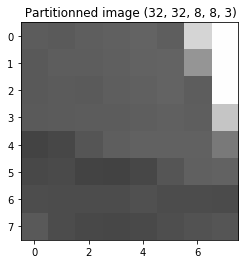

In [29]:
# Step 1 : divide in 8x8 matrixes (optional)
def tile_image(cropped) : 
    divided = np.array((cropped.shape[0] // 8) * [(cropped.shape[1] // 8) * [np.zeros((8, 8, 3))]])
    for i in range(cropped.shape[0]):
        for j in range(cropped.shape[1]):
            divided[i//8][j//8][i % 8][j % 8] = cropped[i][j]
            # Step 2 : Normalize : cropped[i][j] - 128
            #print(i//8, j//8, i % 8, j % 8)
    return divided
tiled = tile_image(cropped)       
plt.title(" Partitionned image " + str(np.shape(tiled)))
plt.imshow(tiled[5][2].astype('uint8'))

In [30]:
"""from PIL import Image
img = Image.open('Moire.jpg')
img_yuv = img.convert('YCbCr')

image = asarray(img_yuv)
n = 120
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
cropped_yuv = image[n:n+256,n:n + 256]
plt.title(" Image " + str(np.shape(cropped_yuv)))

plt.imshow(cropped_yuv)"""

'from PIL import Image\nimg = Image.open(\'Moire.jpg\')\nimg_yuv = img.convert(\'YCbCr\')\n\nimage = asarray(img_yuv)\nn = 120\nplt.figure(figsize = (10,10))\nplt.subplot(1,2,1)\ncropped_yuv = image[n:n+256,n:n + 256]\nplt.title(" Image " + str(np.shape(cropped_yuv)))\n\nplt.imshow(cropped_yuv)'

In [31]:
# Step 2 (useless in the case of grayscaled image) : Convert to YUV
def RGBtoYUV(px):
    R = px[0]
    G = px[1]
    B = px[2]
    Y = 0.299 * R + 0.587 * G + 0.114 * B
    U = -0.14713 * R - 0.28886 * G + 0.436 * B
    V = 0.615*R - 0.51498 * G - 0.10001 * B
    
    return [Y, U, V]

def YUVtoRGB(px):
    Y = px[0];
    U = px[1];
    V = px[2];
    R = Y + 1.13983 * V
    G = Y - 0.39465 * U - 0.58060 * V
    B = Y + 2.03211 * U
    
    return [R, G, B]

def matRGBtoYUV(mat):
    for i in range(8):
        for j in range(8):
            mat[i][j] = RGBtoYUV(mat[i][j])
            
def matYUVtoRGB(mat):
    for i in range(8):
        for j in range(8):
            mat[i][j] = YUVtoRGB(mat[i][j])

"""for i in range(divided.shape[0]):
    for j in range(divided.shape[1]):
        matRGBtoYUV(divided[i][j])

plt.subplot(1, 2, 1)        
plt.imshow(divided[3][4].astype('uint8'))
        
for i in range(divided.shape[0]):
    for j in range(divided.shape[1]):
        matYUVtoRGB(divided[i][j])
plt.subplot(1, 2, 2)     
plt.imshow(divided[3][4].astype('uint8'))"""

"for i in range(divided.shape[0]):\n    for j in range(divided.shape[1]):\n        matRGBtoYUV(divided[i][j])\n\nplt.subplot(1, 2, 1)        \nplt.imshow(divided[3][4].astype('uint8'))\n        \nfor i in range(divided.shape[0]):\n    for j in range(divided.shape[1]):\n        matYUVtoRGB(divided[i][j])\nplt.subplot(1, 2, 2)     \nplt.imshow(divided[3][4].astype('uint8'))"

In [32]:
# Step 3 : DWT

def subsampling(x, d):
    p = 2
    if d == 0:
        y = x[::p, :]
    elif d == 1:
        y = x[:, ::p]
    return y

# Below is a circular convolution implemented. 
def cconv(x, h, d):
    if d == 1:
        return np.transpose(cconv(np.transpose(x), h, 0))
    y = np.zeros(x.shape)
    p = len(h)
    pc = int(round( float((p - 1) / 2 )))
    for i in range(0, p):
        y = y + h[i] * np.roll(x, pc-i, axis=0)
    return y

h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
h = h/norm(h) ## make sure the filter has norm 1.
u = power(-ones(len(h)-1),range(1,len(h))) # alternate +1/-1
g = concatenate(([0], h[-1:0:-1] * u))
print("low-pass filter associated with the scaling function",h)
print("high-pass filter associated with the wavelet function",g)

low-pass filter associated with the scaling function [ 0.          0.48296291  0.8365163   0.22414387 -0.12940952]
high-pass filter associated with the wavelet function [ 0.          0.12940952  0.22414387 -0.8365163   0.48296291]


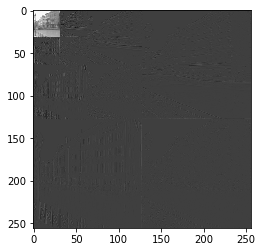

In [33]:
#Step 3 : Wavelet transform
def coarse(image,d):
    # d is the dimension along which the operation is performed.
    # the formula to be implemented is the convolution of x by h along the dimension d.
    return subsampling(cconv(image, h, d), d) #filtre passe bas sur l'image

def fine(image,d):
    # d is the dimension along which the operation is performed.
    # the formula to be implemented is the convolution of x by g along the dimension d.
    return subsampling(cconv(image, g, d), d) #filtre passe haut sur l'image

def W_0(image,wavelet_coeff=None):
    # start with the first dimension index 0 to get coarse and fine description along this axis
    
    # process again the previous results to get coarse and fine description along the axis of index 1.
    # you thus should have 4 sub-images of the same size which is the initial image size divided by 4 (divide columns and rows by 2).
    
    # concatenate your results in an array called results
    c = coarse(image, 0)
    f = fine(image, 0)
    
    cc = coarse(c, 1)
    cf = coarse(f, 1)
    fc = fine(c, 1)
    ff = fine(f, 1)
    
    res1 = concatenate([cc, fc], axis = 0)
    res2 = concatenate([cf, ff], axis = 0)
    return concatenate([res1, res2], axis = 1)
    

def WaveletTransform(image,iterations =1):
    ## iterate the 1step wavelet transform implemented above.
    if iterations == 0 :
        return image
    
    half = shape(image)[0] // 2
    
    w0 = W_0(image)
    LL = w0[:half, :half]
    LH = w0[:half, half:]
    HL = w0[half:, :half]
    HH = w0[half:, half:]
    
    LL = WaveletTransform(LL, iterations - 1)
    
    res1 = np.concatenate([LL, HL], axis = 0)
    res2 = np.concatenate([LH, HH], axis = 0)
    return np.concatenate([res1, res2], axis = 1)

it = 3
Wt = WaveletTransform(cropped, it)
plt.imshow(Wt)

(256, 256)
(65536,)


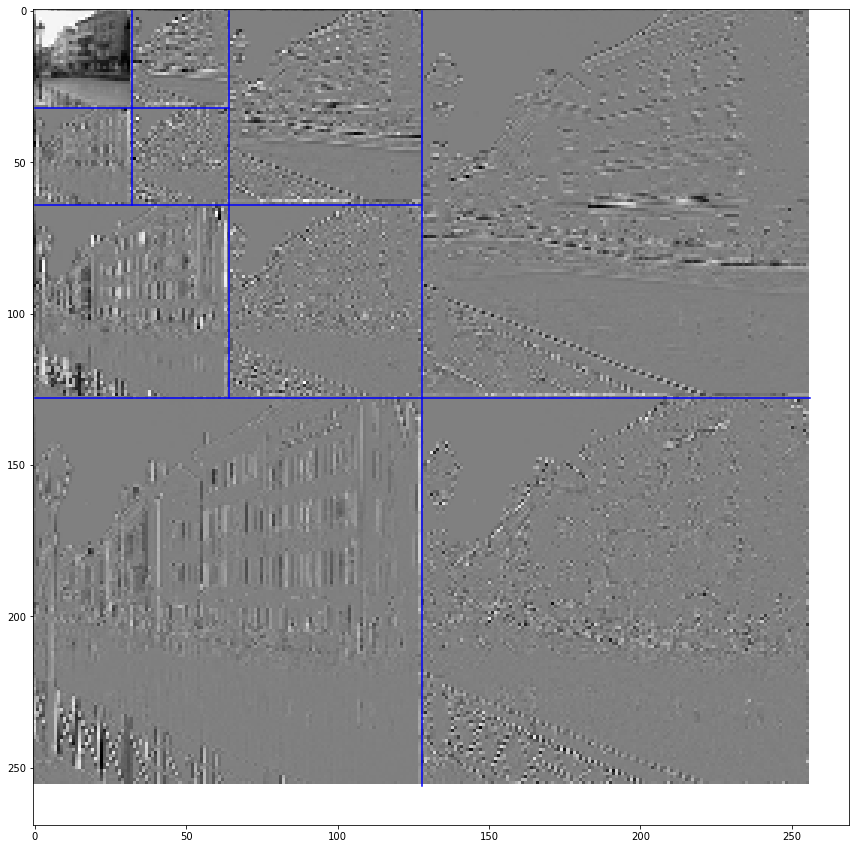

In [34]:
def rescale(f,a=0,b=1):
    ## function that rescale f between a and b.
    rang = f.max() - f.min()
    g = (f - f.min()).copy()
    if rang > 0:
        g = g / rang
    return a + g*(b-a)

def rescaleWav(A):
    ## function dedicated to a proper rescale of wavelet representation (particular case of the previous one).
    sup = abs(A).max()
    B = A.copy()
    if sup > 0:
        B = .5 + .5 * A / sup
    return B
    
def PlotWavelet(wavelet, iterations=1):
    ## Plot the wavelet representation, need to specify the number of iterations (or scales at which the FWT is computed).
    n = wavelet.shape[1]
    Jmax = int(np.log2(n)) - 1
    Jmin = Jmax - iterations + 1
    
    U = wavelet.copy()
    for j in np.arange(Jmax, Jmin - 1, -1):
        U[:2 ** j:,    2 ** j:2 **
            (j + 1):] = rescaleWav(U[:2 ** j:, 2 ** j:2 ** (j + 1):])
        U[2 ** j:2 ** (j + 1):, :2 **
          j:] = rescaleWav(U[2 ** j:2 ** (j + 1):, :2 ** j:])
        U[2 ** j:2 ** (j + 1):, 2 ** j:2 ** (j + 1):] = (
            rescaleWav(U[2 ** j:2 ** (j + 1):, 2 ** j:2 ** (j + 1):]))
    # coarse scale
    U[:2 ** j:, :2 ** j:] = rescale(U[:2 ** j:, :2 ** j:])
    # plot underlying image
    plt.figure(figsize=(15, 15))
    plt.imshow(U)
    # display crosses
    for j in np.arange(Jmax, Jmin - 1, -1):
        plt.plot([0, 2 ** (j + 1)], [2 ** j, 2 ** j], 'b')
        plt.plot([2 ** j, 2 ** j], [0, 2 ** (j + 1)], 'b')
    return U

U = PlotWavelet(Wt, it)
flattenU = U.flatten('F')
flattenU = [int(floor(x * 255)) for x in flattenU]
print(shape(Wt))
print(shape(flattenU))

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 1 0 0]
 [1 1 1 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 1 0]]


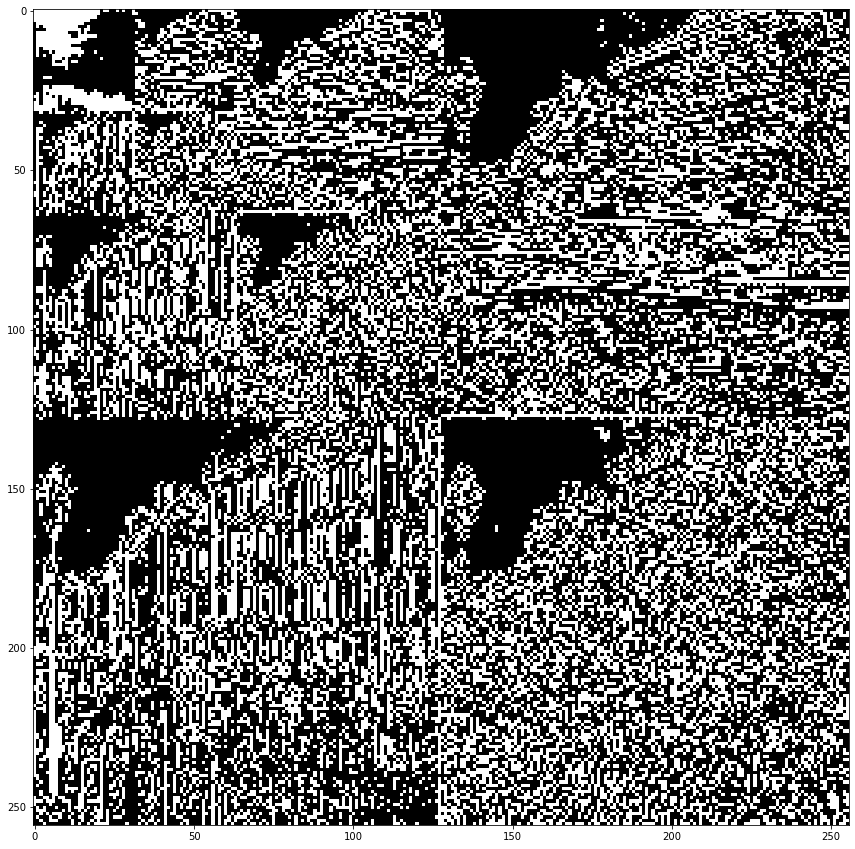

In [37]:
#Step 4 : bit plane coding
import struct

#convert a bit into binary
def intToBits(input) : 
    output = [int(x) for x in '{:08b}'.format(input)]
    return output

#convert a list of int into a list of list of bits
def intListToBits(input) :
    output = [intToBits(x) for x in input]
    return output

#return 1 if MSP, else 0
def MSP(input) : 
    output = [x[0] for x in input]
    return output

#add 0 in the list while the list's length is a multiple of 8
def resizeList(input) : 
    length = len(input)
    res = length % 8
    while(res < 8) : 
        input.append(0)
        res = res + 1
    return input
    
def compressRow(row) : 
    output = sum([int(b) << int(i) for i, b in enumerate(row[::-1])])
    return output

def compressAllRows(rows) : 
    output = [compressRow(row) for row in rows]
    return output
    
def compress(image) : 
    binaryImage = intListToBits(image)
    msp = MSP(binaryImage)
    #resized_msp = resizeList(msp)
    resized_msp = np.reshape(msp, (len(msp) // 8, 8))
    return compressAllRows(resized_msp)


"""ex = [180, 4, 80, 33, 201, 
      102, 27, 11, 160, 28, 
      224, 1, 133, 67, 144
]
res = compress(ex)
print(res)
#res = compress(flattenWt)"""

res = compress(flattenU)
#print(shape(flattenU))
#print(len(res))
#print(res)

def decompressImage(image) :
    binaryImage = intListToBits(image)  
    res = np.array(binaryImage).reshape(256, 256)
    print(res)
    return res

compressedImage = decompressImage(res)
compressedImage = compressedImage.transpose()
plt.figure(figsize=(15, 15))
plt.imshow(compressedImage)

In [44]:
#Step 5 : EBCOT tier 1
# Example array
bloc = [\
 [4, 11, -13, 2],
 [20, -14, 17, -9],
 [-34, 14, 3, -11],
 [-17, 29, -2, 6],
 [5, 51, 4, -5],
 [8, -15, 8, 10],
 [13, 1, -12, -15],
 [-16, 5, 6, -11],
 [42, -7, 25, 10],
 [14, 13, -56, 15]]


# Coding primitives : 
# Run Length : 0
# Zero Coding : 1
# Magnitude Refinement : 2
# Sign Coding : 3

def countPlanes(bloc):
    n = max([abs(x) for x in flatten(bloc)])
    return int(ceil(log2(n)))

def isSignificant(x, n):
    return abs(x) > (2 ** n)

def intToUNI(x):
    return ("0" if x < 2 else "1") + ("1" if x % 2 else "0")

def clamp(val, min_val, max_val):
    return max(min_val, min(val, max_val))

def predictSign(i, j, sign):
    # assuming we're in LH sub-band
    h = clamp(sign[clamp(j - 1, 0, len(sign) - 1)][i] + sign[clamp(j + 1, 0, len(sign) - 1)][i], -1, 1)
    v = clamp(sign[j][clamp(i - 1, 0, len(sign[j]) - 1)] + sign[j][clamp(i + 1, 0, len(sign[j]) - 1)], -1, 1)
    if(h == 1):
        if(v == 1):
            return ("SC4", 1)
        if(v == 0):
            return ("SC3", 1)
        if(v == 1):
            return ("SC2", 1)
    if(h == 0):
        if(v == 1):
            return ("SC1", 1)
        if(v == 0):
            return ("SC0", 1)
        if(v == 1):
            return ("SC1", -1)
    if(h == 1):
        if(v == 1):
            return ("SC2", -1)
        if(v == 0):
            return ("SC3", -1)
        if(v == 1):
            return ("SC4", -1)
        
def zcContext(i, j, significance):
    # assuming we're in LH sub-band
    print(len(significance[j]))
    print("context of", i, j) # i = 3 j = 2
    h = (significance[j - 1][i] if j - 1 >= 0 else 0) + \
              (significance[j + 1][i] if j + 1 < len(significance) else 0)
    v = (significance[j][i - 1] if i - 1 >= 0 else 0) + \
              (significance[j][i + 1] if i + 1 < len(significance[j]) else 0)
    d = (significance[j - 1][i - 1] if j - 1 >= 0 and i - 1 >= 0 else 0) + \
              (significance[j - 1][i + 1] if j - 1 >= 0 and i + 1 < len(significance[j]) else 0) + \
        (significance[j + 1][i - 1] if j + 1 < len(significance) and i - 1 >= 0 else 0) + \
              (significance[j + 1][i + 1] if j + 1 < len(significance) and i + 1 < len(significance[j]) else 0)
    print(h, v, d)
    if(h == 0):
        if(v == 0):
            if(d == 0):
                return "ZC0"
            if(d == 1):
                return "ZC1"
            if(d >= 2):
                return "ZC2"
        if(v == 1):
            return "ZC3"
        if(v == 2):
            return "ZC4"
    if (h == 1):
        if(v == 0):
            if(d == 0):
                return "ZC5"
            if(d >= 1):
                return "ZC6"
        if(v >= 1):
            return "ZC7"
    if (h == 2):
        return "ZC8"

def runLength(column, n, result):
    print("RL of column", column)
    for i in range(len(column)):
        if (isSignificant(column[i], n)):
            # 1 means out RL mode
            result.append(("1", "RL"))
            # next code is the position of the first signifying coeff
            result.append((intToUNI(i), "UNI"))
            return i

    # 0 means columns of 0's
    result.append(("0", "RL"))
    return -1

def signCoding(val, i, j, signs, result):
    print("SC of value", val)
    (context, sign) = predictSign(i, j, signs)
    # 0 means sign prediction is correct, 1 otherwise
    result.append(("0" if np.sign(sign) == np.sign(val) else "1", context))
    
def zeroCoding(column, i, j, n, significance, sign, result):
    print("ZC of column", column)
    for k in range(len(column)):
        context = zcContext(i + k, j, significance)
        print(context)
        if (isSignificant(column[k], n)):
            significance[j][i + k] = 1
            result.append(("1", context))
            signCoding(column[k], i, j, sign, result)
        else:
            result.append(("0", context))
            

def cleanUp(bloc, n):
    coeff = False
    neighboorCoeff = False
    result = []
    sign = numpy.zeros(shape=(len(bloc), len(bloc[0])), dtype=numpy.int)
    significance = numpy.zeros(shape=(len(bloc), len(bloc[0])), dtype=numpy.int)
    for j in range(len(bloc)):
        print("CU of column", j)
        coeff = np.any(significance[j])
        neighboorCoeff = (False if j <= 0 else np.any(significance[j - 1])) or \
            (False if j >= len(bloc) - 1 else np.any(significance[j - 1]))
        if(not coeff and not neighboorCoeff):
            i = runLength(bloc[j], n, result)
            if(i >= 0):
                print("i = ", i)
                signCoding(bloc[j][i], i, j, sign, result)
                significance[j][i] = 1
                i = i + 1
                zeroCoding(bloc[j][i:], i, j, n, significance, sign, result)
        else:
            zeroCoding(bloc[j], 0, j, n, significance, sign, result)
    
    return result

def significancePropagation(bloc, n, result, significance):
    pass
                

def codeBlock(bloc):
    planes = countPlanes(bloc)
    #for n in range(planes - 1, -1, -1):
    n = planes - 1
    print("Coding of n =", n, "bit plane.")
    print(cleanUp(bloc, n))
    
codeBlock(bloc)

Coding of n = 5 bit plane.
CU of column 0
RL of column [4, 11, -13, 2]
CU of column 1
RL of column [20, -14, 17, -9]
CU of column 2
RL of column [-34, 14, 3, -11]
i =  0
SC of value -34
ZC of column [14, 3, -11]
4
context of 1 2
0 1 0
ZC3
4
context of 2 2
0 0 0
ZC0
4
context of 3 2
0 0 0
ZC0
CU of column 3
ZC of column [-17, 29, -2, 6]
4
context of 0 3
1 0 0
ZC5
4
context of 1 3
0 0 1
ZC1
4
context of 2 3
0 0 0
ZC0
4
context of 3 3
0 0 0
ZC0
CU of column 4
RL of column [5, 51, 4, -5]
i =  1
SC of value 51
ZC of column [4, -5]
4
context of 2 4
0 1 0
ZC3
4
context of 3 4
0 0 0
ZC0
CU of column 5
ZC of column [8, -15, 8, 10]
4
context of 0 5
0 0 1
ZC1
4
context of 1 5
1 0 0
ZC5
4
context of 2 5
0 0 1
ZC1
4
context of 3 5
0 0 0
ZC0
CU of column 6
RL of column [13, 1, -12, -15]
CU of column 7
RL of column [-16, 5, 6, -11]
CU of column 8
RL of column [42, -7, 25, 10]
i =  0
SC of value 42
ZC of column [-7, 25, 10]
4
context of 1 8
0 1 0
ZC3
4
context of 2 8
0 0 0
ZC0
4
context of 3 8
0 0 0
Z

## Links
### Jpeg 2000
- https://www2.ulb.ac.be/cours/acohen/travaux_2006_infodoc/CompressionNumerique/TypeDonneesImageJPEG2000.htm
- https://www2.ulb.ac.be/cours/acohen/travaux_2006_infodoc/CompressionNumerique/TypeDonneesImageJPEG.htm#Le_JPEG
- https://web.stanford.edu/class/ee398a/handouts/lectures/10-JPEG2000.pdf
- http://ljk.imag.fr/membres/Valerie.Perrier/SiteWeb/node13.html

### RGB to YUV
- https://stackoverflow.com/questions/17892346/how-to-convert-rgb-yuv-rgb-both-ways
- https://fr.wikipedia.org/wiki/YUV

### Quantization
- https://www.whydomath.org/node/wavlets/jpeg2000quantization.html
- https://www.imageeprocessing.com/2015/10/bit-plane-compression.html

### EBCOT Tier 1
- http://d.xav.free.fr/ebcot/